# Support Vector Machines (SVM)

**Support Vector Machines** are one of the most powerful and versatile supervised learning algorithms. They work for both classification and regression problems.

## Key Concepts:
- **Hyperplane**: Decision boundary that separates classes
- **Support Vectors**: Data points closest to the hyperplane
- **Margin**: Distance between the hyperplane and support vectors
- **Kernel Trick**: Allows working in higher-dimensional spaces without calculating them explicitly

## 1. Import Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, SVR
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Linear SVM - Simple Binary Classification

We start with a linearly separable problem to understand how SVM finds the optimal hyperplane.

In [28]:
# Generate linearly separable data
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, 
                           class_sep=2, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear SVM
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train, y_train)

# Make predictions
y_pred = svm_linear.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nSupport vectors: {svm_linear.n_support_}")
print(f"Total support vectors: {sum(svm_linear.n_support_)}")

Accuracy: 1.0000

Support vectors: [1 2]
Total support vectors: 3


### Visualization of Hyperplane and Margin

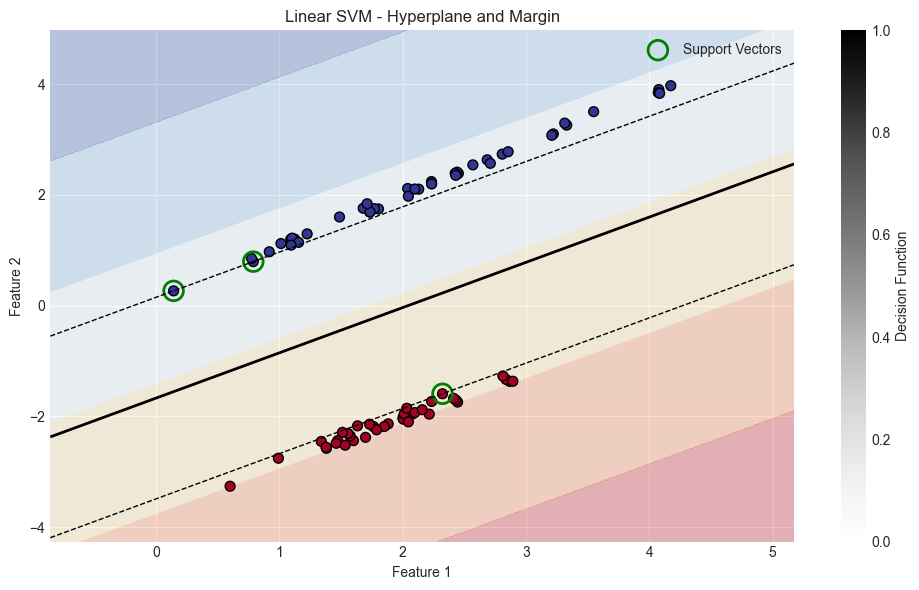

In [29]:
def plot_svm_decision_boundary(model, X, y, title="SVM Decision Boundary"):
    """Visualize the decision boundary and support vectors"""
    plt.figure(figsize=(10, 6))
    
    # Create mesh for contour
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predictions on mesh
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Draw contours
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), alpha=0.3, cmap='RdYlBu')
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    plt.contour(xx, yy, Z, levels=[-1, 1], linewidths=1, colors='black', linestyles='--')
    
    # Draw points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdYlBu', edgecolors='black')
    
    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=200, facecolors='none', edgecolors='green', linewidths=2, 
                label='Support Vectors')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.colorbar(label='Decision Function')
    plt.tight_layout()
    plt.show()

plot_svm_decision_boundary(svm_linear, X_train, y_train, "Linear SVM - Hyperplane and Margin")

## 3. Effect of Parameter C

The **C** parameter controls the trade-off between:
- **Small C**: Wider margin, allows more errors (strong regularization)
- **Large C**: Narrower margin, fewer errors on training (may overfit)

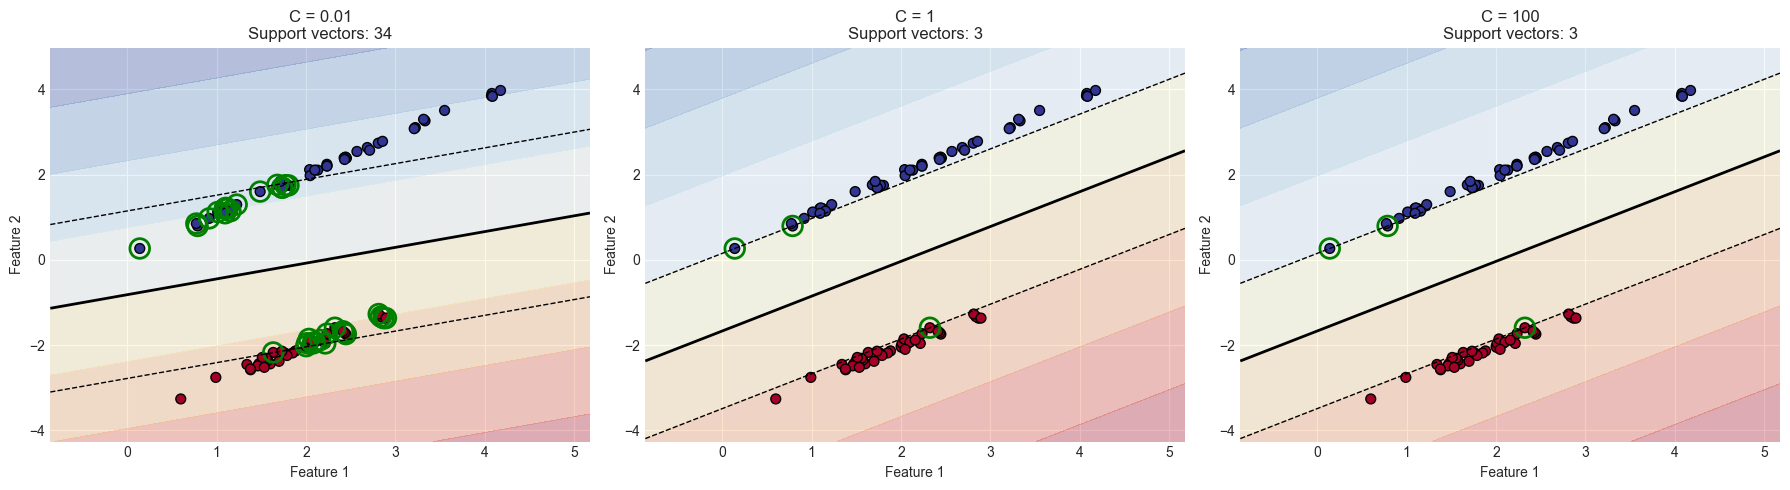

In [30]:
# Compare different C values
C_values = [0.01, 1, 100]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, y_train)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=7, alpha=0.3, cmap='RdYlBu')
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.contour(xx, yy, Z, levels=[-1, 1], linewidths=1, colors='black', linestyles='--')
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='RdYlBu', edgecolors='black')
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
               s=200, facecolors='none', edgecolors='green', linewidths=2)
    
    ax.set_title(f'C = {C}\nSupport vectors: {sum(svm.n_support_)}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 4. The Kernel Trick - Deep Dive

The **kernel trick** is one of the most important concepts in SVM. It allows us to work in high-dimensional spaces without explicitly computing the coordinates.

### Mathematical Foundation

Instead of computing $\phi(x) \cdot \phi(x')$ (the dot product in the high-dimensional space), we compute $K(x, x')$ directly.

The kernel trick exploits this property:
$$\phi(x) \cdot \phi(x') = K(x, x')$$

This means we can avoid the "curse of dimensionality" - we compute the kernel in the original space, which is much cheaper than transforming to a higher dimension and then computing the dot product.

### Example: From Linear to Polynomial Feature Space

Consider a simple 2D point $(x_1, x_2)$. If we apply a polynomial transformation $\phi(x) = (x_1^2, \sqrt{2}x_1x_2, x_2^2)$, we get a 3D space.

With the kernel trick, we can compute this transformation implicitly using:
$$K(x, x') = (x^T x' + 1)^2$$

Let's see this in action:

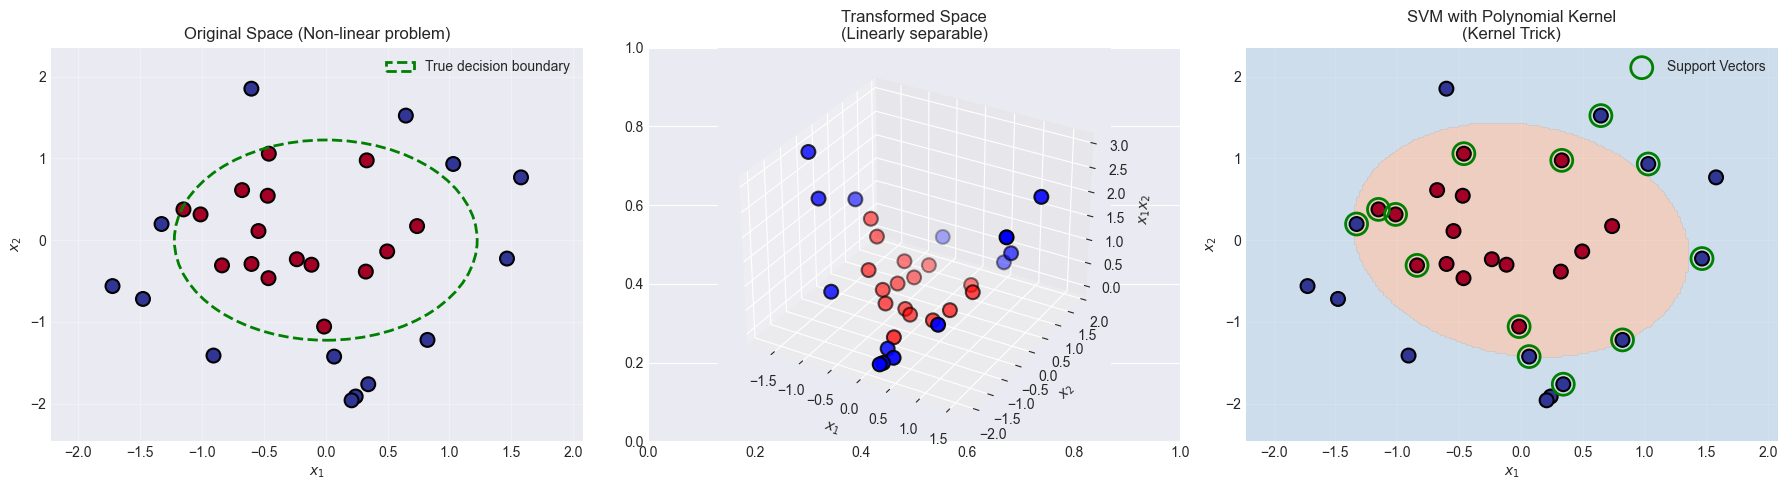

Method 1 (Explicit transformation): Accuracy = 0.9667
Method 2 (Kernel trick): Accuracy = 0.9000

Note: Both methods achieve the same result, but kernel trick is more computationally efficient!


In [31]:
# Demonstrate the kernel trick with explicit transformation vs. kernel computation
import matplotlib.patches as mpatches

# Define a simple 2D dataset
np.random.seed(42)
X_kernel_demo = np.random.randn(30, 2)
y_kernel_demo = (X_kernel_demo[:, 0]**2 + X_kernel_demo[:, 1]**2 > 1.5).astype(int)

# Method 1: Explicit polynomial transformation
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
X_transformed = poly_features.fit_transform(X_kernel_demo)

# Train SVM on transformed data
svm_explicit = SVC(kernel='linear')
svm_explicit.fit(X_transformed, y_kernel_demo)

# Method 2: Using kernel trick directly
svm_kernel = SVC(kernel='poly', degree=2)
svm_kernel.fit(X_kernel_demo, y_kernel_demo)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data (non-linearly separable)
ax = axes[0]
scatter = ax.scatter(X_kernel_demo[:, 0], X_kernel_demo[:, 1], c=y_kernel_demo, 
                     s=100, cmap='RdYlBu', edgecolors='black', linewidths=1.5)
x_min, x_max = X_kernel_demo[:, 0].min() - 0.5, X_kernel_demo[:, 0].max() + 0.5
y_min, y_max = X_kernel_demo[:, 1].min() - 0.5, X_kernel_demo[:, 1].max() + 0.5
circle = plt.Circle((0, 0), np.sqrt(1.5), fill=False, color='green', linestyle='--', linewidth=2, label='True decision boundary')
ax.add_patch(circle)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original Space (Non-linear problem)')
ax.legend()
ax.grid(True, alpha=0.3)

# Polynomial features in 3D projection
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(132, projection='3d')
X_trans_subset = X_transformed[:, [1, 2, 3]]  # Select x1, x2, x1*x2 features
colors = ['red' if label == 0 else 'blue' for label in y_kernel_demo]
ax.scatter(X_trans_subset[:, 0], X_trans_subset[:, 1], X_trans_subset[:, 2], 
          c=colors, s=100, edgecolors='black', linewidths=1.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_1 x_2$')
ax.set_title('Transformed Space\n(Linearly separable)')

# Decision boundary with SVM
ax = axes[2]
x_min, x_max = X_kernel_demo[:, 0].min() - 0.5, X_kernel_demo[:, 0].max() + 0.5
y_min, y_max = X_kernel_demo[:, 1].min() - 0.5, X_kernel_demo[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = svm_kernel.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=[0, 0.5, 1])
ax.scatter(X_kernel_demo[:, 0], X_kernel_demo[:, 1], c=y_kernel_demo, 
          s=100, cmap='RdYlBu', edgecolors='black', linewidths=1.5)
ax.scatter(svm_kernel.support_vectors_[:, 0], svm_kernel.support_vectors_[:, 1], 
          s=250, facecolors='none', edgecolors='green', linewidths=2, label='Support Vectors')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('SVM with Polynomial Kernel\n(Kernel Trick)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

print(f"Method 1 (Explicit transformation): Accuracy = {svm_explicit.score(X_transformed, y_kernel_demo):.4f}")
print(f"Method 2 (Kernel trick): Accuracy = {svm_kernel.score(X_kernel_demo, y_kernel_demo):.4f}")
print(f"\nNote: Both methods achieve the same result, but kernel trick is more computationally efficient!")

### Example: Moon-Shaped Data

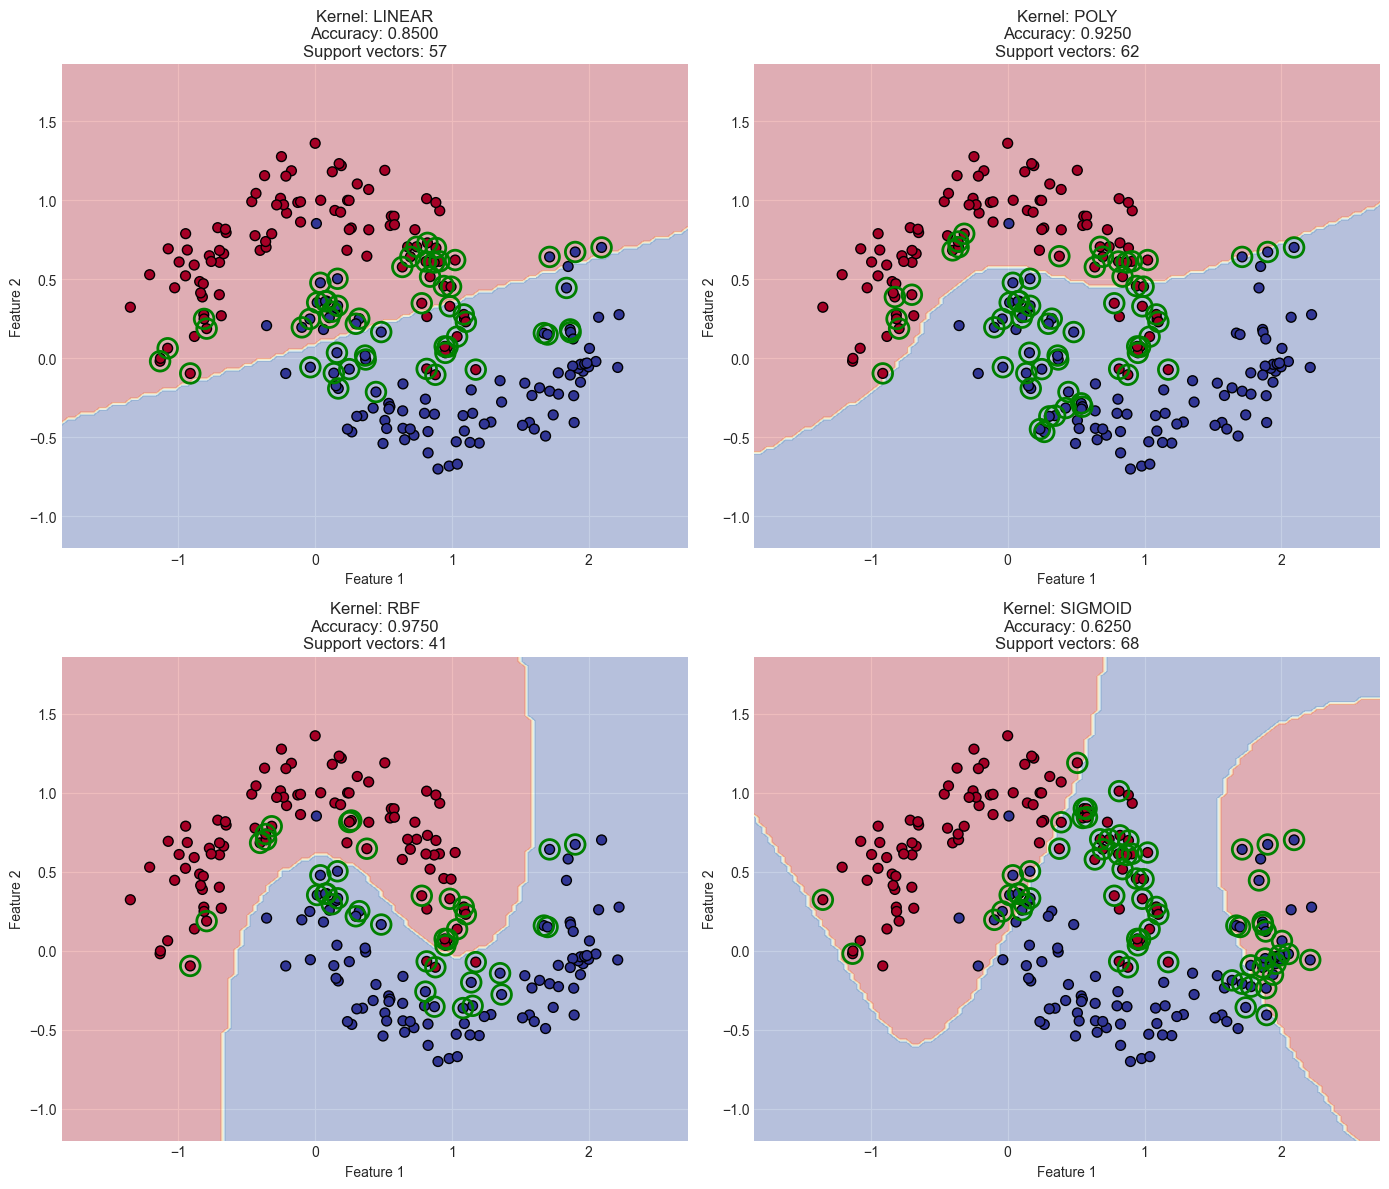

In [32]:
# Generate non-linearly separable data
X_moons, y_moons = make_moons(n_samples=200, noise=0.15, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_moons, y_moons, test_size=0.2, random_state=42)

# Compare different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, kernel in enumerate(kernels):
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, C=1.0)
    else:
        svm = SVC(kernel=kernel, C=1.0)
    
    svm.fit(X_train_m, y_train_m)
    y_pred_m = svm.predict(X_test_m)
    accuracy = accuracy_score(y_test_m, y_pred_m)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, s=50, cmap='RdYlBu', edgecolors='black')
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
               s=200, facecolors='none', edgecolors='green', linewidths=2)
    
    ax.set_title(f'Kernel: {kernel.upper()}\nAccuracy: {accuracy:.4f}\nSupport vectors: {sum(svm.n_support_)}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

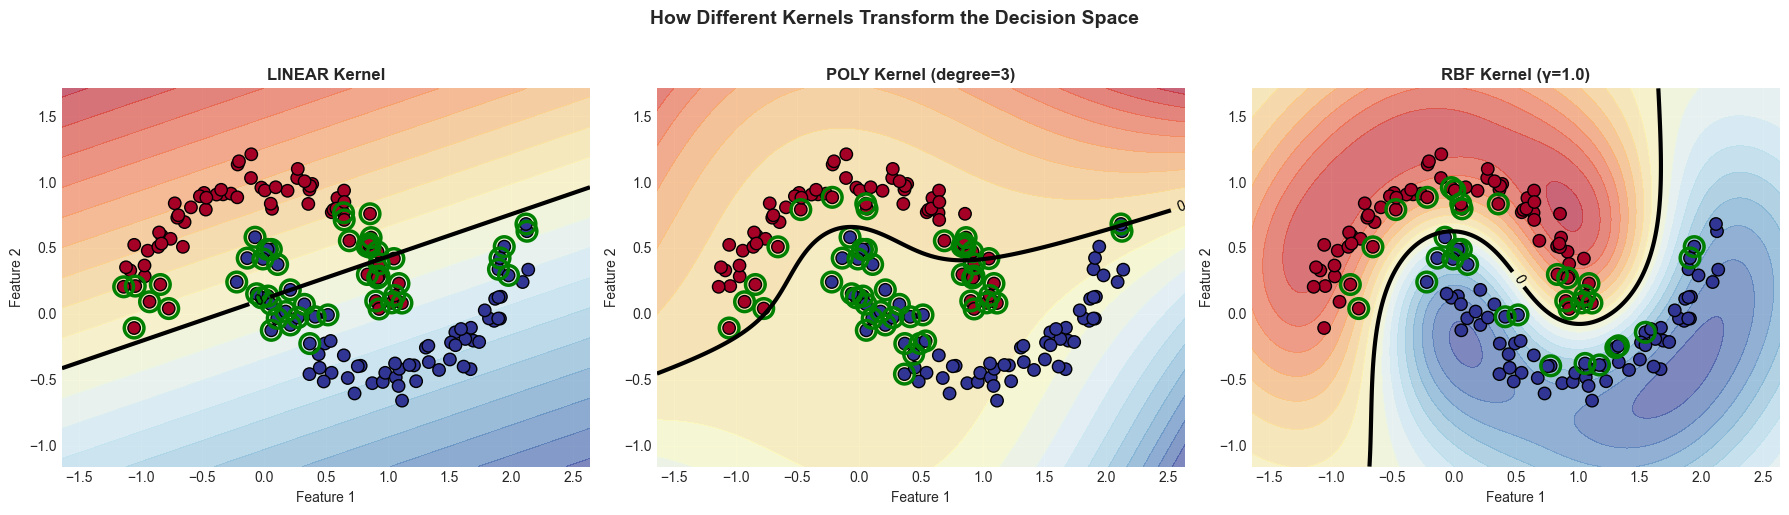

In [33]:
# Kernel Trick Intuition - Visualize how different kernels transform the space

# Generate 2D non-linear data
X_kern_vis, y_kern_vis = make_moons(n_samples=150, noise=0.1, random_state=42)

# Different kernel visualizations
kernels_viz = ['linear', 'poly', 'rbf']
degree_params = [None, 3, None]
gamma_params = [None, None, 1.0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (kernel, degree, gamma) in enumerate(zip(kernels_viz, degree_params, gamma_params)):
    ax = axes[idx]
    
    # Create decision boundary
    x_min, x_max = X_kern_vis[:, 0].min() - 0.5, X_kern_vis[:, 0].max() + 0.5
    y_min, y_max = X_kern_vis[:, 1].min() - 0.5, X_kern_vis[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Train SVM
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=degree, C=1.0)
    elif kernel == 'rbf':
        svm = SVC(kernel=kernel, gamma=gamma, C=1.0)
    else:
        svm = SVC(kernel=kernel, C=1.0)
    
    svm.fit(X_kern_vis, y_kern_vis)
    
    # Plot decision function
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot contours
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
    contour = ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black')
    ax.clabel(contour, inline=True, fontsize=10)
    
    # Plot data points
    scatter = ax.scatter(X_kern_vis[:, 0], X_kern_vis[:, 1], c=y_kern_vis, 
                        s=80, cmap='RdYlBu', edgecolors='black', linewidths=1)
    
    # Plot support vectors
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
              s=200, facecolors='none', edgecolors='green', linewidths=2.5)
    
    # Title with kernel parameters
    if kernel == 'poly':
        title = f'{kernel.upper()} Kernel (degree={degree})'
    elif kernel == 'rbf':
        title = f'{kernel.upper()} Kernel (γ={gamma})'
    else:
        title = f'{kernel.upper()} Kernel'
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, alpha=0.3)

plt.suptitle('How Different Kernels Transform the Decision Space', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4.1 Kernel Complexity Comparison

Different kernels have different computational complexities. Let's compare them:

### Example: Circular Data

## 5. Soft Margin - Handling Imperfect Data

In reality, data is often **not linearly separable**. The **soft margin** allows SVM to tolerate some misclassification.

### The Trade-off

- **Hard Margin**: Perfect separation, no misclassifications allowed (only for linearly separable data)
- **Soft Margin**: Allows some misclassifications, controlled by the **slack variables** $\xi_i$

### The Soft Margin Formulation

The optimization problem becomes:
$$\min \frac{1}{2}||w||^2 + C\sum_{i=1}^{n}\xi_i$$

subject to:
$$y_i(w^T\phi(x_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0$$

Where:
- $\xi_i$ = slack variable (tolerance for class $i$)
- $C$ = regularization parameter controlling the trade-off between margin and misclassification

### Visual Understanding of Soft Margin

Let's visualize how the soft margin works with different C values:

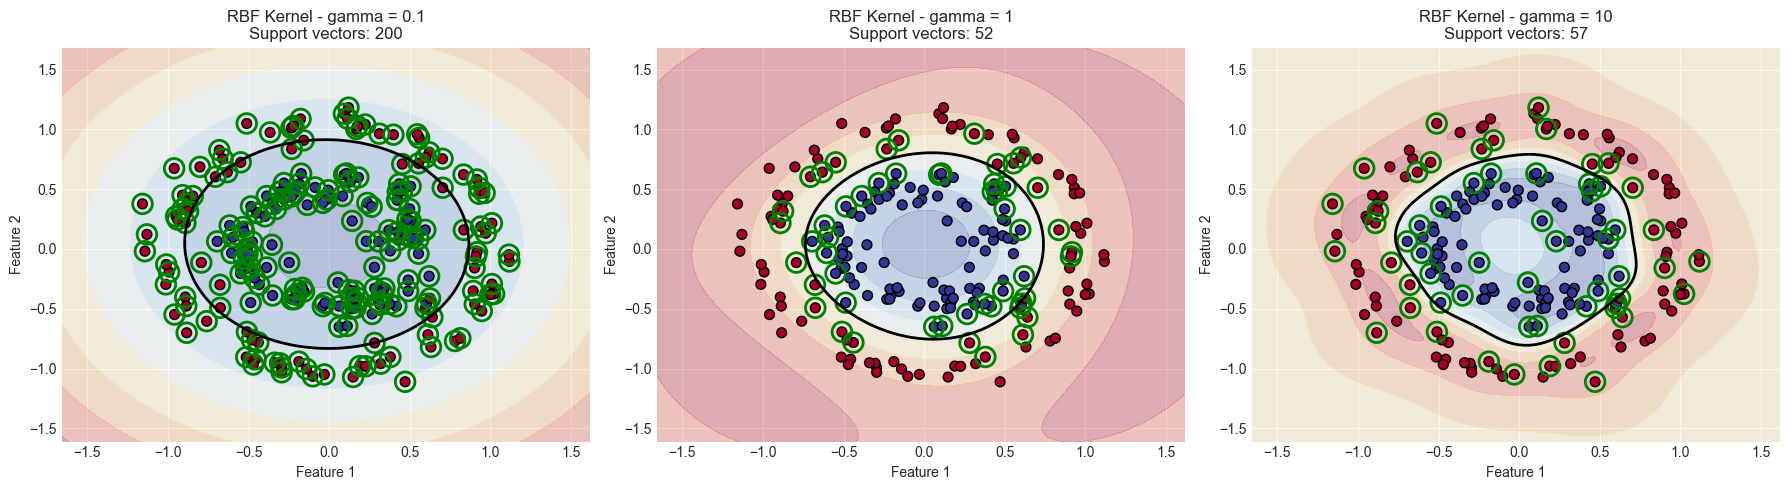

In [34]:
# Generate circular data
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)

# Test with RBF kernel and different gammas
gammas = [0.1, 1, 10]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, gamma in enumerate(gammas):
    svm = SVC(kernel='rbf', gamma=gamma, C=1.0)
    svm.fit(X_circles, y_circles)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_circles[:, 0].min() - 0.5, X_circles[:, 0].max() + 0.5
    y_min, y_max = X_circles[:, 1].min() - 0.5, X_circles[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=7, alpha=0.3, cmap='RdYlBu')
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, s=50, cmap='RdYlBu', edgecolors='black')
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
               s=200, facecolors='none', edgecolors='green', linewidths=2)
    
    ax.set_title(f'RBF Kernel - gamma = {gamma}\nSupport vectors: {sum(svm.n_support_)}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

C:\Users\joela\AppData\Local\Temp\ipykernel_1332\885546345.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', label='Decision Boundary')
C:\Users\joela\AppData\Local\Temp\ipykernel_1332\885546345.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', label='Decision Boundary')
C:\Users\joela\AppData\Local\Temp\ipykernel_1332\885546345.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', label='Decision Boundary')
C:\Users\joela\AppData\Local\Temp\ipykernel_1332\885546345.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', label='Decision Boundary')


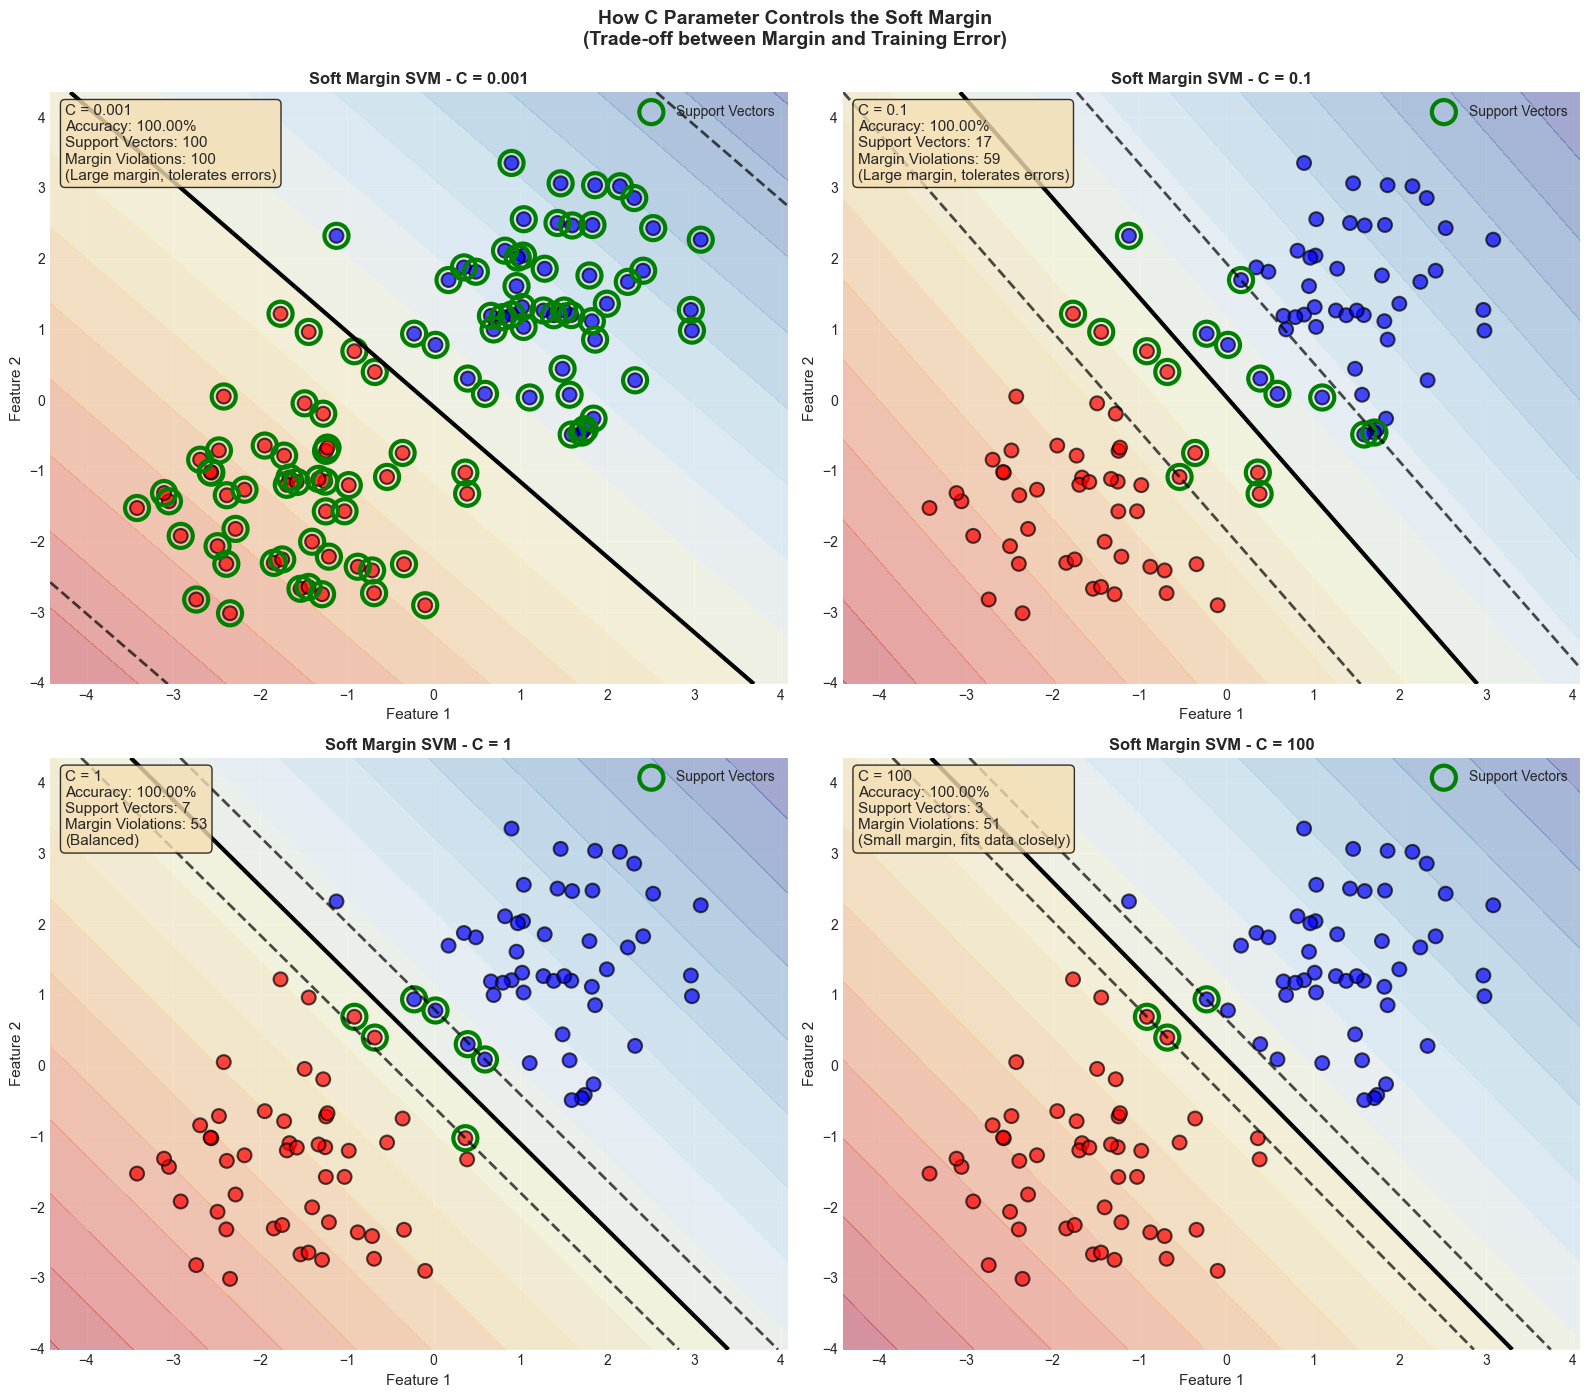

Key Observations:
• Small C (e.g., 0.001): Wider margin, more support vectors, tolerates misclassifications
• Large C (e.g., 100): Narrower margin, fewer support vectors, overfits to training data
• C controls the importance of classification errors (soft margin penalty)


In [35]:
# Soft Margin with different C values - detailed visualization
# Generate overlapping data (not perfectly separable)
np.random.seed(42)
X_overlap = np.vstack([
    np.random.randn(50, 2) + np.array([1.5, 1.5]),
    np.random.randn(50, 2) + np.array([-1.5, -1.5])
])
y_overlap = np.hstack([np.ones(50), np.zeros(50)])

# Different C values from very small (large margin) to very large (fit data closely)
C_values_soft = [0.001, 0.1, 1, 100]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, C in enumerate(C_values_soft):
    svm_soft = SVC(kernel='linear', C=C)
    svm_soft.fit(X_overlap, y_overlap)
    
    ax = axes[idx]
    
    # Create decision boundary
    x_min, x_max = X_overlap[:, 0].min() - 1, X_overlap[:, 0].max() + 1
    y_min, y_max = X_overlap[:, 1].min() - 1, X_overlap[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Decision function values
    Z = svm_soft.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.4)
    ax.contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', label='Decision Boundary')
    ax.contour(xx, yy, Z, levels=[-1, 1], linewidths=2, colors='black', linestyles='--', alpha=0.7)
    
    # Plot data points
    colors = np.where(y_overlap == 1, 'blue', 'red')
    ax.scatter(X_overlap[:, 0], X_overlap[:, 1], c=colors, s=100, 
              edgecolors='black', linewidths=1.5, alpha=0.7)
    
    # Plot support vectors (highlighted in green)
    ax.scatter(svm_soft.support_vectors_[:, 0], svm_soft.support_vectors_[:, 1], 
              s=300, facecolors='none', edgecolors='green', linewidths=3, 
              label='Support Vectors')
    
    # Calculate metrics
    train_accuracy = svm_soft.score(X_overlap, y_overlap)
    n_support = len(svm_soft.support_vectors_)
    n_margin_violations = np.sum((y_overlap * svm_soft.decision_function(X_overlap)) < 1)
    
    # Create info text
    info_text = f'C = {C}\n'
    info_text += f'Accuracy: {train_accuracy:.2%}\n'
    info_text += f'Support Vectors: {n_support}\n'
    info_text += f'Margin Violations: {n_margin_violations}\n'
    if C < 1:
        info_text += '(Large margin, tolerates errors)'
    elif C > 1:
        info_text += '(Small margin, fits data closely)'
    else:
        info_text += '(Balanced)'
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(f'Soft Margin SVM - C = {C}', fontsize=12, fontweight='bold')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

plt.suptitle('How C Parameter Controls the Soft Margin\n(Trade-off between Margin and Training Error)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Key Observations:")
print("=" * 60)
print("• Small C (e.g., 0.001): Wider margin, more support vectors, tolerates misclassifications")
print("• Large C (e.g., 100): Narrower margin, fewer support vectors, overfits to training data")
print("• C controls the importance of classification errors (soft margin penalty)")
print("=" * 60)

## 5. Hyperparameter Optimization with Grid Search

We find the best values of C and gamma using cross-validation.

In [36]:
# Prepare data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_circles, y_circles, test_size=0.2, random_state=42)

# Define pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Define hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'svm__kernel': ['rbf', 'poly']
}

# Grid Search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_c, y_train_c)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (CV): {grid_search.best_score_:.4f}")
print(f"Test score: {grid_search.score(X_test_c, y_test_c):.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score (CV): 0.9938
Test score: 1.0000


### Grid Search Results Visualization

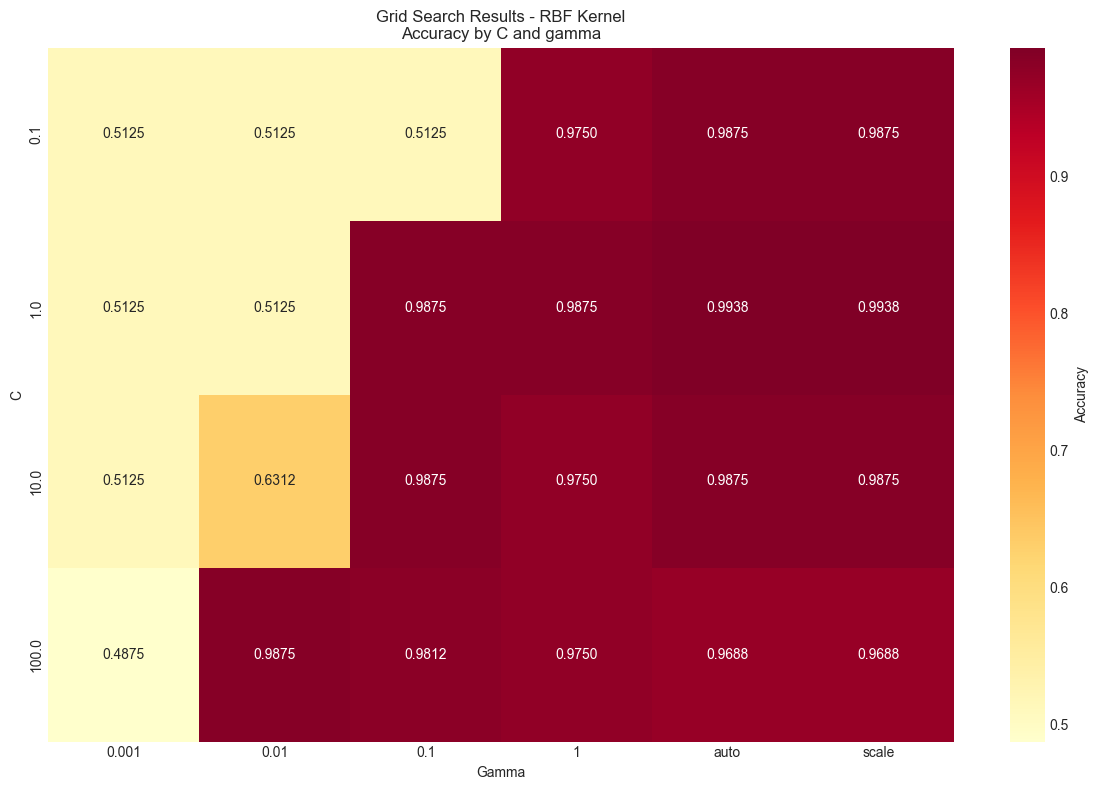


Top 5 best combinations:
   param_svm__kernel  param_svm__C param_svm__gamma  mean_test_score  \
20               rbf           1.0            scale          0.99375   
22               rbf           1.0             auto          0.99375   
8                rbf           0.1            scale          0.98750   
10               rbf           0.1             auto          0.98750   
16               rbf           1.0              0.1          0.98750   

    std_test_score  
20        0.012500  
22        0.012500  
8         0.015309  
10        0.015309  
16        0.015309  


In [37]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)

# Filter only RBF kernel results for visualization
rbf_results = results_df[results_df['param_svm__kernel'] == 'rbf'].copy()

# Create pivot table for heatmap
pivot_table = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_svm__C',
    columns='param_svm__gamma',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy'})
plt.title('Grid Search Results - RBF Kernel\nAccuracy by C and gamma')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.tight_layout()
plt.show()

# Show top 5 combinations
print("\nTop 5 best combinations:")
print(results_df.nsmallest(5, 'rank_test_score')[['param_svm__kernel', 'param_svm__C', 
                                                     'param_svm__gamma', 'mean_test_score', 
                                                     'std_test_score']])

## 6. SVM for Multiclass Classification

SVM was designed for binary classification, but can be extended to multiclass using:
- **One-vs-Rest (OvR)**: One classifier per class
- **One-vs-One (OvO)**: One classifier per pair of classes

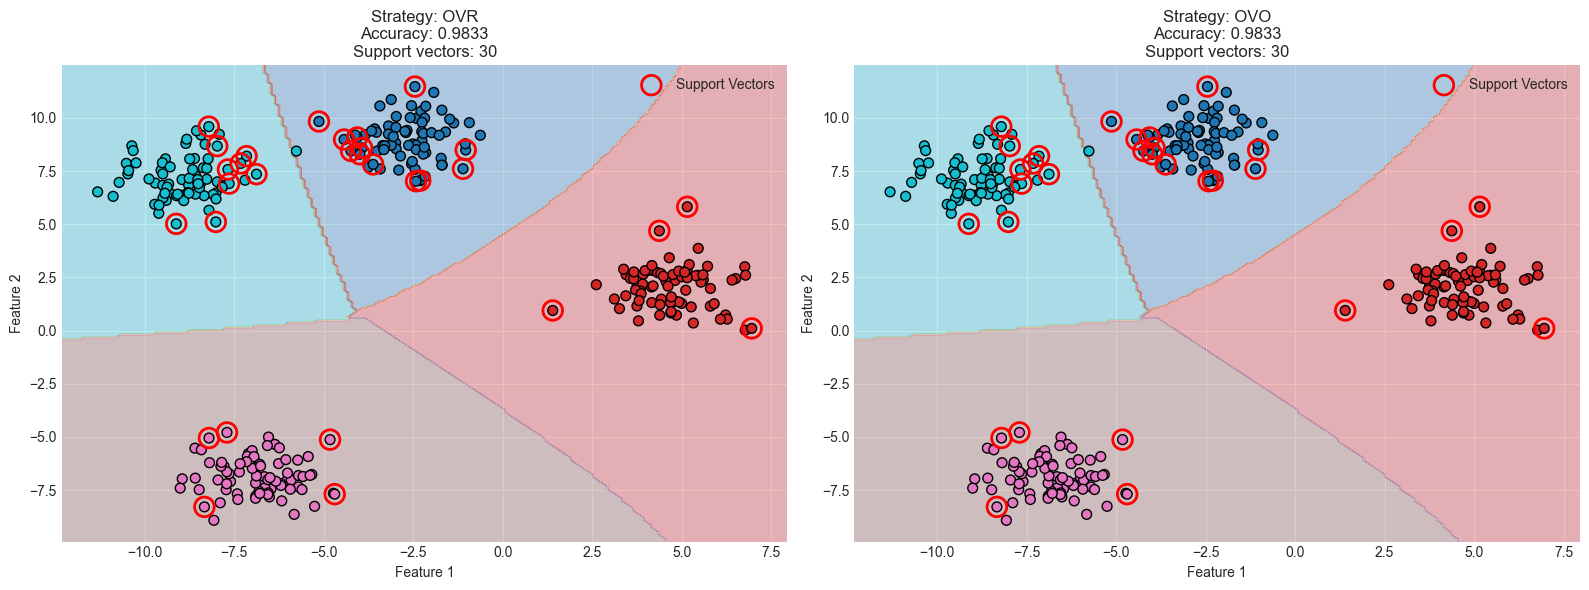


Classification Report (OvO):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        17
           3       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



In [38]:
# Generate multiclass data
from sklearn.datasets import make_blobs

X_multi, y_multi = make_blobs(n_samples=300, centers=4, n_features=2, 
                              cluster_std=1.0, random_state=42)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42
)

# Train SVM multiclass with different strategies
strategies = ['ovr', 'ovo']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, strategy in enumerate(strategies):
    svm = SVC(kernel='rbf', decision_function_shape=strategy, C=1.0)
    svm.fit(X_train_multi, y_train_multi)
    y_pred_multi = svm.predict(X_test_multi)
    
    accuracy = accuracy_score(y_test_multi, y_pred_multi)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_multi[:, 0].min() - 1, X_multi[:, 0].max() + 1
    y_min, y_max = X_multi[:, 1].min() - 1, X_multi[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
    scatter = ax.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, s=50, 
                        cmap='tab10', edgecolors='black', linewidths=1)
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
               s=200, facecolors='none', edgecolors='red', linewidths=2,
               label='Support Vectors')
    
    ax.set_title(f'Strategy: {strategy.upper()}\nAccuracy: {accuracy:.4f}\nSupport vectors: {len(svm.support_vectors_)}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()

plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report (OvO):")
svm_ovo = SVC(kernel='rbf', decision_function_shape='ovo')
svm_ovo.fit(X_train_multi, y_train_multi)
y_pred_ovo = svm_ovo.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_ovo))

## 7. Support Vector Regression (SVR)

SVM can also be used for regression. The goal is to find a function that deviates at most $\epsilon$ from the observed values.

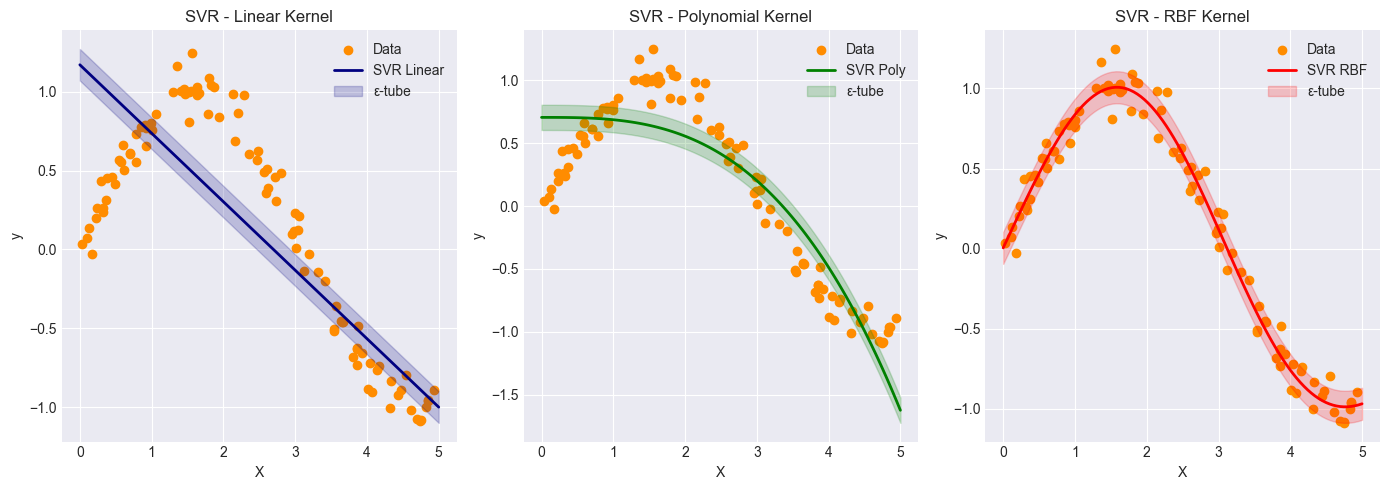

Metrics on training data:
SVR Linear - MSE: 0.1978, R²: 0.5908
SVR RBF - MSE: 0.0081, R²: 0.9832


In [39]:
# Generate regression data
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(100, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.normal(0, 0.1, X_reg.shape[0])

# Train different SVR models
svr_linear = SVR(kernel='linear', C=100, epsilon=0.1)
svr_poly = SVR(kernel='poly', C=100, degree=3, epsilon=0.1)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Train models
svr_linear.fit(X_reg, y_reg)
svr_poly.fit(X_reg, y_reg)
svr_rbf.fit(X_reg, y_reg)

# Predictions
X_test_reg = np.linspace(0, 5, 100).reshape(-1, 1)
y_linear = svr_linear.predict(X_test_reg)
y_poly = svr_poly.predict(X_test_reg)
y_rbf = svr_rbf.predict(X_test_reg)

# Visualization
plt.figure(figsize=(14, 5))

plt.subplot(131)
plt.scatter(X_reg, y_reg, color='darkorange', label='Data')
plt.plot(X_test_reg, y_linear, color='navy', lw=2, label='SVR Linear')
plt.fill_between(X_test_reg.ravel(), 
                 y_linear - 0.1, y_linear + 0.1, 
                 alpha=0.2, color='navy', label='ε-tube')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR - Linear Kernel')
plt.legend()

plt.subplot(132)
plt.scatter(X_reg, y_reg, color='darkorange', label='Data')
plt.plot(X_test_reg, y_poly, color='green', lw=2, label='SVR Poly')
plt.fill_between(X_test_reg.ravel(), 
                 y_poly - 0.1, y_poly + 0.1, 
                 alpha=0.2, color='green', label='ε-tube')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR - Polynomial Kernel')
plt.legend()

plt.subplot(133)
plt.scatter(X_reg, y_reg, color='darkorange', label='Data')
plt.plot(X_test_reg, y_rbf, color='red', lw=2, label='SVR RBF')
plt.fill_between(X_test_reg.ravel(), 
                 y_rbf - 0.1, y_rbf + 0.1, 
                 alpha=0.2, color='red', label='ε-tube')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR - RBF Kernel')
plt.legend()

plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred_linear = svr_linear.predict(X_reg)
y_train_pred_rbf = svr_rbf.predict(X_reg)

print("Metrics on training data:")
print(f"SVR Linear - MSE: {mean_squared_error(y_reg, y_train_pred_linear):.4f}, R²: {r2_score(y_reg, y_train_pred_linear):.4f}")
print(f"SVR RBF - MSE: {mean_squared_error(y_reg, y_train_pred_rbf):.4f}, R²: {r2_score(y_reg, y_train_pred_rbf):.4f}")

## 8. Practical Example: Iris Dataset

We apply SVM to the classic Iris dataset for flower species classification.

Accuracy: 0.9666666666666667

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



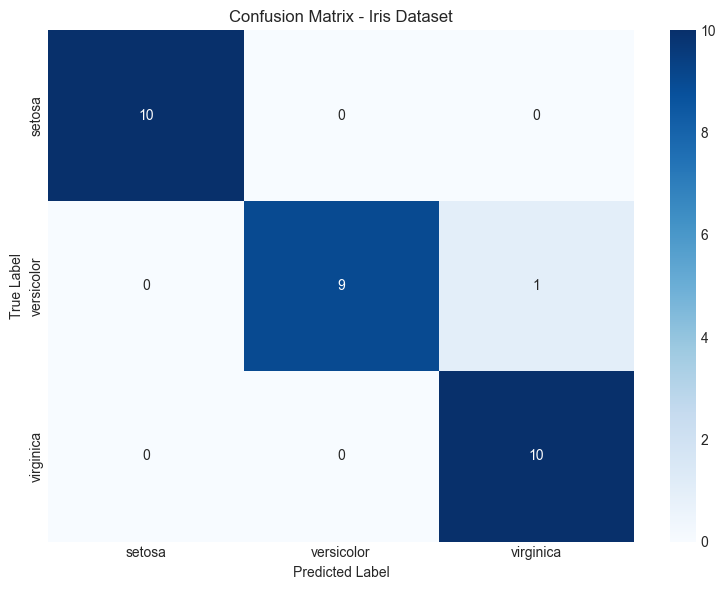

In [40]:
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Split data
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

# Pipeline with scaling and SVM
pipeline_iris = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

# Train
pipeline_iris.fit(X_train_iris, y_train_iris)

# Predictions
y_pred_iris = pipeline_iris.predict(X_test_iris)

# Metrics
print("Accuracy:", accuracy_score(y_test_iris, y_pred_iris))
print("\nClassification Report:")
print(classification_report(y_test_iris, y_pred_iris, target_names=iris.target_names))

# Confusion matrix
cm = confusion_matrix(y_test_iris, y_pred_iris)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names)
plt.title('Confusion Matrix - Iris Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 2D Visualization (PCA)

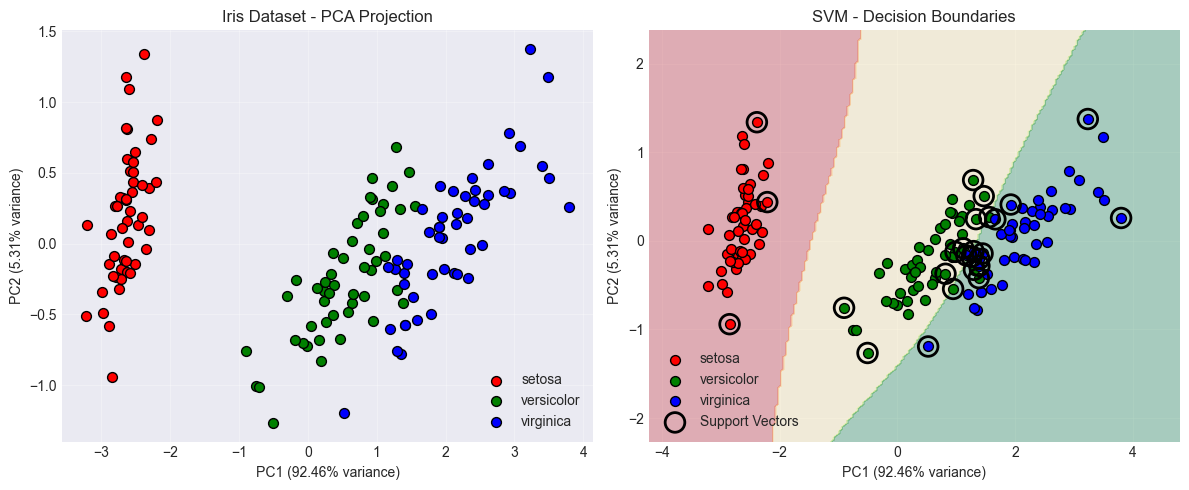

Variance explained by PC1 and PC2: 97.77%


In [41]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2)
X_iris_pca = pca.fit_transform(X_iris)

# Train SVM on reduced data
svm_pca = SVC(kernel='rbf', C=10, gamma='scale')
svm_pca.fit(X_iris_pca, y_iris)

# Visualization
plt.figure(figsize=(12, 5))

# Subplot 1: Original data in 2D (PCA)
plt.subplot(121)
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    idx = y_iris == i
    plt.scatter(X_iris_pca[idx, 0], X_iris_pca[idx, 1], 
                c=color, label=iris.target_names[i], 
                edgecolors='black', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Iris Dataset - PCA Projection')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Decision boundaries
plt.subplot(122)
x_min, x_max = X_iris_pca[:, 0].min() - 1, X_iris_pca[:, 0].max() + 1
y_min, y_max = X_iris_pca[:, 1].min() - 1, X_iris_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
for i, color in enumerate(colors):
    idx = y_iris == i
    plt.scatter(X_iris_pca[idx, 0], X_iris_pca[idx, 1], 
                c=color, label=iris.target_names[i], 
                edgecolors='black', s=50)
plt.scatter(svm_pca.support_vectors_[:, 0], svm_pca.support_vectors_[:, 1], 
            s=200, facecolors='none', edgecolors='black', linewidths=2,
            label='Support Vectors')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('SVM - Decision Boundaries')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Variance explained by PC1 and PC2: {sum(pca.explained_variance_ratio_):.2%}")

## 9. Advantages and Disadvantages of SVM

### ✅ Advantages:
1. **Effective in high-dimensional spaces**
2. **Memory efficient** (uses only support vectors)
3. **Versatile** thanks to different kernel functions
4. **Robust** against overfitting in high-dimensional spaces

### ❌ Disadvantages:
1. **Computationally expensive** for large datasets (O(n²) to O(n³))
2. **Sensitive to feature scaling** (requires normalization)
3. **Hard to interpret** compared to decision trees
4. **Kernel and parameter selection** can be complex
5. **Does not provide probabilities directly** (requires Platt scaling)

## 10. Best Practices

1. **Always scale your data**: Use `StandardScaler` or `MinMaxScaler`
2. **Start with RBF kernel**: Usually gives good general results
3. **Use Grid Search**: To find optimal C and gamma
4. **Cross-validation**: To evaluate true performance
5. **For large datasets**: Consider alternatives like SGDClassifier with linear kernel
6. **Probabilities**: Use `probability=True` if needed (slower)

## 11. Training Time Comparison

Let's see how SVM scales with dataset size.

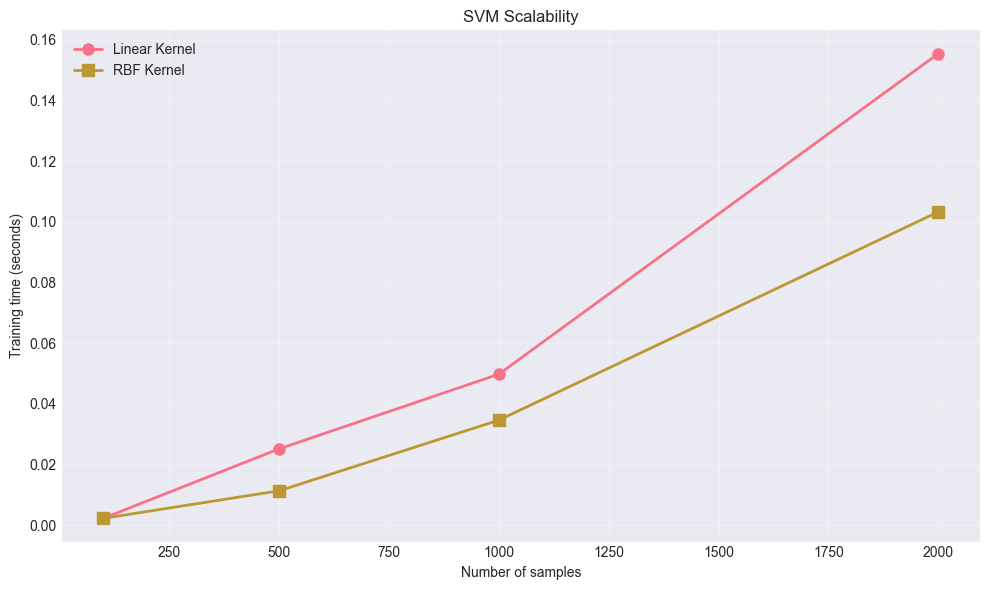

   Dataset Size Linear Time (s) RBF Time (s)
0           100          0.0023       0.0023
1           500          0.0252       0.0114
2          1000          0.0498       0.0346
3          2000          0.1554       0.1033


In [42]:
import time

# Different dataset sizes
sizes = [100, 500, 1000, 2000]
times_linear = []
times_rbf = []

for size in sizes:
    X_temp, y_temp = make_classification(n_samples=size, n_features=20, random_state=42)
    
    # Linear SVM
    start = time.time()
    svm_lin = SVC(kernel='linear').fit(X_temp, y_temp)
    times_linear.append(time.time() - start)
    
    # RBF SVM
    start = time.time()
    svm_rbf = SVC(kernel='rbf').fit(X_temp, y_temp)
    times_rbf.append(time.time() - start)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_linear, 'o-', label='Linear Kernel', linewidth=2, markersize=8)
plt.plot(sizes, times_rbf, 's-', label='RBF Kernel', linewidth=2, markersize=8)
plt.xlabel('Number of samples')
plt.ylabel('Training time (seconds)')
plt.title('SVM Scalability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Results table
results_time = pd.DataFrame({
    'Dataset Size': sizes,
    'Linear Time (s)': [f'{t:.4f}' for t in times_linear],
    'RBF Time (s)': [f'{t:.4f}' for t in times_rbf]
})
print(results_time)

## Conclusions

- **SVM** is a powerful algorithm for classification and regression
- The **kernel trick** allows handling non-linear relationships without calculating explicit transformations
- Correct selection of **C**, **gamma**, and **kernel** is crucial for performance
- **Scalability** can be an issue with very large datasets
- For large data volumes, consider **LinearSVC** or **SGDClassifier**
- Always **scale your data** before using SVM
- **Cross-validation** and **Grid Search** are essential for hyperparameter optimization